# T4

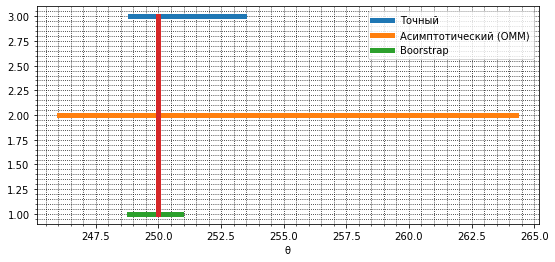

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter

Theta = 250
N = 100
beta = 0.95
alpha = (1-beta)/2

def conf_int(x):
    return (max(x)/(1+(1-alpha)**(1/len(x))), max(x)/(1+alpha**(1/len(x))))

def asym_conf_int(x):
    alpha1 = np.mean(x)
    alpha2 = np.mean(x**2)
    return (alpha1*2/3 - 1.3*((alpha2-alpha1**2)/len(x))**0.5, alpha1*2/3 + 1.3*((alpha2-alpha1**2)/len(x))**0.5)

def bootstrap_conf_int(x):
    delta = sorted([max([x[random.randint(0, len(x)-1)] for i in range(len(x))])/2 - max(x)/2 for i in range(1000)])
    l = max(x)/2 - delta[int((1-alpha)*1000)]
    r = max(x)/2 - delta[int(alpha*1000)]
    return (l,r)

intervals = [conf_int(x := np.array([(random.uniform(Theta,2*Theta)) for i in range(N)])), 
             asym_conf_int(x), 
             bootstrap_conf_int(x)]

fig, ax = plt.subplots(figsize=(9, 4))
labels = ["Точный", "Асимптотический (ОММ)", "Boorstrap"]
ax.minorticks_on()
ax.grid(which='major', color='k', linestyle=':')
ax.grid(which='minor', color='k', linestyle=':')
ax.set_xlabel('\u03B8')
for i in range(len(intervals)):
    ax.plot(intervals[i], (len(intervals)-i, len(intervals)-i), linewidth=5.0, label=labels[i])
ax.plot((Theta, Theta),(1, len(intervals)),linewidth=5.0)
ax.legend()

# T5

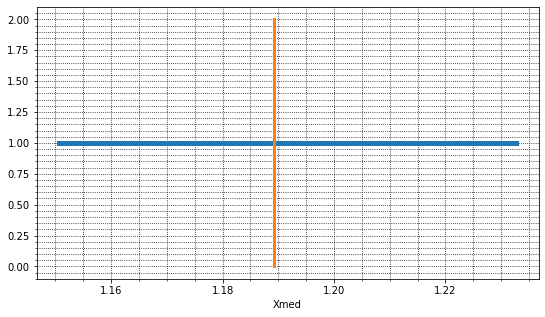

In [24]:
from scipy.stats import pareto

Theta = 5
u1 = -1.96
u2 = 1.96
B_p = 1000
B_np = 25000
med = 2**(1/(Theta-1))

def conf_med(x):
    return (2 ** (m := np.mean(np.log(x))) * (1 - m * np.log(2) * u2 / N ** 0.5), 
            2 ** m * (1 - m * np.log(2) * u1 / N ** 0.5))

def asym_conf_1(x):
    return (1 + 1 / (m := np.mean(np.log(x))) - (m * N ** 0.5) ** (-1) * u2, 
            1 + 1 / m - (m * N ** 0.5) ** (-1) * u1)

def bootstrap_conf_unpar(x):
    te = 1 + np.mean(np.log(x)) ** (-1)
    delta = sorted([1+np.mean(np.log([x[random.randint(0,N-1)] for i in range(N)]))**-1 - te for i in range(B_p)])
    return (te - delta[int((1-alpha)*B_p)], te - delta[int(alpha*B_p)])

def bootstr_conf_par(x):
    te = 1 + np.mean(np.log(x)) ** (-1)
    delta = sorted([1 + np.mean(np.log(pareto(te - 1).rvs(size=N))) ** (-1) - te for i in range(B_np)])
    return (te - delta[int((1-alpha)*B_np)], te - delta[int(alpha*B_np)])

intervals = [asym_conf_1(x := pareto(Theta-1).rvs(size=N)),
             bootstrap_conf_unpar(x),
             bootstr_conf_par(x)]

fig, ax = plt.subplots(figsize=(9, 5))
ax.minorticks_on()
ax.grid(which='major', color = 'k', linestyle = ':')
ax.grid(which='minor', color = 'k', linestyle = ':')
ax.set_xlabel('Xmed')
ax.plot(conf_med(x), (1, 1), linewidth=5.0)
ax.plot((med, med), (0, 2), linewidth=3.0)

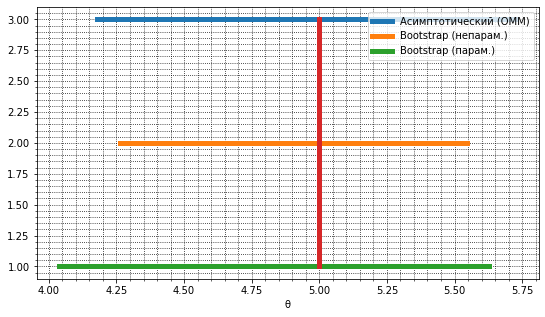

In [25]:
fig, ax = plt.subplots(figsize=(9, 5))
labels = ["Асимптотический (ОММ)", "Bootstrap (непарам.)", "Bootstrap (парам.)"]
ax.minorticks_on()
ax.grid(which='major', color = 'k', linestyle = ':')
ax.grid(which='minor', color = 'k', linestyle = ':')
ax.set_xlabel('\u03B8')
for i in range(len(intervals)):
    ax.plot(intervals[i], (len(intervals)-i, len(intervals)-i) , linewidth=5.0, label=labels[i])
ax.plot((Theta,Theta), (1, len(intervals)), linewidth=5.0)
ax.legend()

/Users/bonderson/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


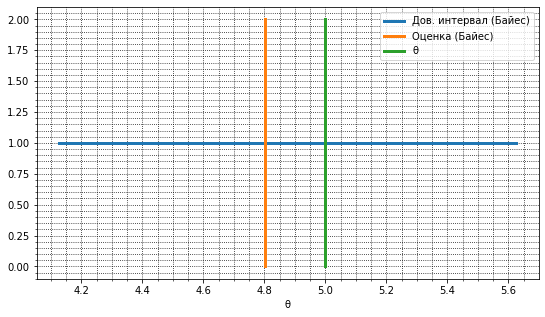

In [28]:
from scipy.integrate import quad

def integrand(te, x):
    return (te - 1) ** N / np.prod(x**te) * np.exp(1-te)

def lev(f, l, t, args):
    s, d, qx = 0, 10**(-4), l
    while s < t:
        s += (f(qx,*args)+f(qx+d,*args))/2*d
        qx += d
    return qx

def bayes(x):
    c = quad(integrand, 1., 100, args=(x))[0] ** (-1)
    return 1 + N / (sum(np.log(x))+1), (lev(integrand, 1, alpha/c, (x,)), lev(integrand, 1, (1-alpha)/c, (x,)))

te, inter = bayes(x)

X = [inter, (te, te), (Theta, Theta)]
Y = [(1, 1), (0, 2), (0, 2)]
labels = ["Дов. интервал (Байес)","Оценка (Байес)","\u03B8"]

fig, ax = plt.subplots(figsize=(9, 5))
ax.minorticks_on()
ax.grid(which='major', color = 'k', linestyle = ':')
ax.grid(which='minor', color = 'k', linestyle = ':')
ax.set_xlabel('\u03B8')
for i in range(3):
    ax.plot(X[i], Y[i], linewidth=3.0, label=labels[i])
ax.legend()